## AI Memory Sytem

This is the demonstration of ai memory system

<img src="../public/Memory.png" width=100% height=500 />

### Working Memory

Working memory encompasses your active understanding and contextualization of immediate information requiring dynamic processing. For a chatbot, this represents the maintenance and manipulation of conversational context observed throughout real-time interactions.

The type of information maintained in working memory consists of active messages and roles, current task/goal parameters, immediate state representations, and contextual processing requirements. This includes message history with associated metadata, conversation state vectors, goal hierarchies, and temporary computational results requiring immediate access.

<img src="https://raw.githubusercontent.com/ALucek/agentic-memory/03eb349dd06f050e4e21bf51d4adace8fbb65524/media/working_diagram.png" width=500 height=500>

It's like a mental workspace where you can briefly keep information active while performing other operations on it.

In [ ]:
https://chat-ai.hari.pitt.edu/c/b5787199-4612-4973-add3-182bf36d98eb


### Long term memory & Short term memory

<img src="../public/calm-memory.png" width=800 height=800 >

Use reasoning node to determine the necessarity of concluding a user query to long term memory and execute infering procedure if worthy.

In [5]:
from classes.Memory import BaseMemory, MemoryItem
from function.mem_proc import memory_extract_decision, summarize_lstm_from_query
from function.answer_generation import generate_answer_with_memory
from function.vector_store import add_to_memory
from langchain_core.messages import HumanMessage, AIMessage

conversation = []
stm_context = []

while True:
    # Get user input
    query = input("User:")
    print(f"HUMAN: {query}")

    # Exit the loop
    if query.upper() == "EXIT":
        break

    conversation.append(HumanMessage(content=query))

    isWorthy: bool = memory_extract_decision(query=query)  # noqa: N816
    if isWorthy is True:
        print("<AI Internal>: Activate Memory System")

        # Distill key information
        summary: BaseMemory = summarize_lstm_from_query(query=query)

        if summary.content and summary.type != "N/A":
            print("<AI Internal>: Pass")
        
            # Persis LTM / instruct following converstation if STM
            memo = MemoryItem(
                **summary.model_dump(),
                user_id="drake",
                source="HUMAN",
            )

            memo_sentence = memo.convert_to_sentence()

            if memo.level == "LTM":
                # TODO: add LTM to the vector store
                res = add_to_memory(memo)
                stm_context.append(memo_sentence)
                if res is not None:
                    print(f"<AI Internal>: Memory persisted")
                pass
            else:
                print(f"<AI Internal>: Classified as STM add to context")
                stm_context.append(memo_sentence)

        print(f"<AI Internal>: {memo_sentence}")
    else:
        print(f"<AI Internal>: Not worthy ")

    answer: AIMessage = generate_answer_with_memory(
        question=query,
        ltm_context=[],
        stm_context=stm_context,
        conversation_history=conversation[-4:-1] if len(conversation) > 3 else conversation,
    )

    conversation.append(answer)

    print(f"AI: {answer.content}")

    print("--------------------------------")


HUMAN: hello, what is my name ?
<AI Internal>: Activate Memory System
<AI Internal>: Pass
HUMAN: my favorite food is fried chicken. But it could change
<AI Internal>: Activate Memory System
<AI Internal>: Classified as STM add to context
<AI Internal>: The user's food preference is user's favorite food is fried chicken.
AI: It’s wonderful that you enjoy fried chicken—it’s a classic comfort food! Since you mentioned your favorite food *could* change, I’d love to hear what other foods you’re curious about or if there’s a new dish you’ve tried recently. Exploring different flavors can be a joyful experience, especially when shared with others.  

If you’d like, I could also share some caregiver-friendly meal ideas that are both nutritious and easy to prepare (since caregiving can make cooking challenging). Let me know how I can support you—whether it’s food-related or anything else on your mind.  

For now, I’ll remember that fried chicken is your go-to favorite! 🍗💛  

*(Gentle reminder: 

In [6]:
# New conversation without retrieval

res = generate_answer_with_memory("what is my name and my favorite food so far ?")

print(f"AI: {res.content}")


AI: Since we’ve just started our conversation and I don’t have any long-term memory or chat history to reference, I don’t yet know your name or favorite food. But I’d love to learn more about you! Could you share your name and your favorite food with me? That way, I can remember these details for our future conversations and make our interactions more personal and meaningful.  

For example, you could say:  
*"My name is [Your Name], and I love [Your Favorite Food]!"*  

I’m here to listen and support you in any way I can. 💙


In [7]:
# New converstation with retrieval


from langchain_core.documents import Document
from embedding.vector_store import recall_memory

user_query = "what is my name and my favorite food so far ?"

res: list[Document] = recall_memory(query=user_query, user_id="drake")

for item in res:
    print(f"<AI Internal>: Retrieved relevant memory: {item.page_content}")

answer = generate_answer_with_memory(
    question=user_query,
    ltm_context=res,
)

print(f"AI: {answer.content}")



<AI Internal>: Retrieved relevant memory: user's name is Drake
<AI Internal>: Retrieved relevant memory: user's dad is experiencing increased forgetfulness.
AI: Hello, Drake! Based on my long-term memory, I know your name is Drake, and you're caring for your dad who is experiencing increased forgetfulness—a situation that I know can be both challenging and emotionally heavy at times.  

As for your favorite food, it seems we haven’t had the chance to discuss that yet. Would you like to share what you enjoy? I’d love to learn more about you so I can offer support that feels personal and meaningful.  

How are you feeling today? Is there anything specific you’d like to talk about regarding your dad’s care or your own well-being? I’m here to listen and help.


# Evaluation

First, we will take a look at how smart the determination node is. That is to say, can LLM make right decision on whether or not this query contains valuable information  


In [12]:
import pandas as pd

df = pd.read_csv("data/memory_eval_dataset.csv")

df.head()


,Question,C-worthy,T-Decision,C-Category,C-Conclusion
0,"Hi CaLM, I’m Michael Chen, a 49‑year‑old part‑...",True,True,BIO_INFO,NaN
1,My wife Jenna can only pitch in on weekends; h...,True,True,SOCIAL_CONNECTIONS,NaN
2,Robert usually grows restless around 7 p.m. he...,True,True,CARE_GIVING,NaN
3,Our daughter Emily lives in Boston; what are s...,True,True,SOCIAL_CONNECTIONS,NaN
4,I absorb info fastest in concise checklists—co...,True,True,PREFERENCES,NaN


In [6]:
for index, row in df.iterrows():
    query = row["Question"]

    res = memory_extract_decision(query=query)

    # Update the T-Decision column with the result from memory_extract_decision
    df.at[index, "T-Decision"] = res

    # Print the current row to monitor progress
    print(f"Processed row {index}: {query[:50]}... - Decision: {res}")

df.to_csv("data/memory_eval_dataset.csv", index=False)


/tmp/ipykernel_1602099/1933774916.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, "T-Decision"] = res


Processed row 0: Hi CaLM, I’m Michael Chen, a 49‑year‑old part‑time... - Decision: True
Processed row 1: My wife Jenna can only pitch in on weekends; how c... - Decision: True
Processed row 2: Robert usually grows restless around 7 p.m. here i... - Decision: True
Processed row 3: Our daughter Emily lives in Boston; what are some ... - Decision: True
Processed row 4: I absorb info fastest in concise checklists—could ... - Decision: True
Processed row 5: I unwind by strumming classic‑rock guitar for a fe... - Decision: True
Processed row 6: I’ve started getting lower‑back pain from lifting ... - Decision: True
Processed row 7: Our Labrador, Max, follows Dad everywhere—how migh... - Decision: True
Processed row 8: I mainly use an iPhone 15—can you walk me through ... - Decision: True
Processed row 9: I often second‑guess my decisions for Dad—could yo... - Decision: True
Processed row 10: What evidence‑based strategies best reduce evening... - Decision: False
Processed row 11: How long sho

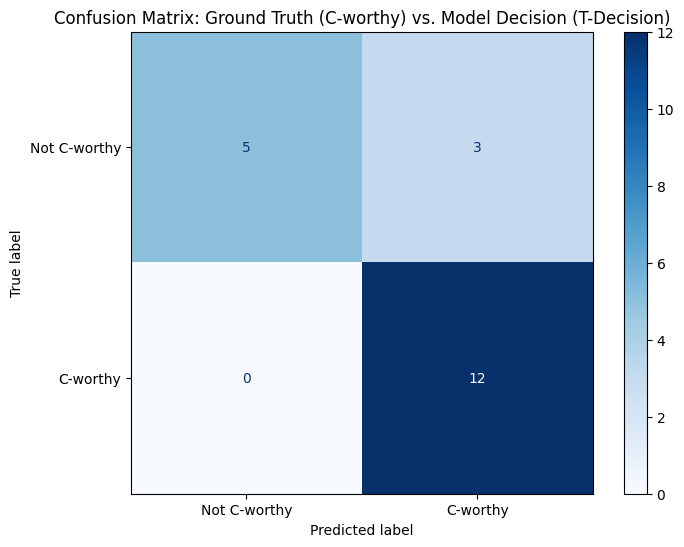

Accuracy: 0.8500
Precision: 0.8000
Recall: 1.0000
F1 Score: 0.8889


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Filter out rows where T-Decision is NaN
filtered_df = df.dropna(subset=['T-Decision'])

# Convert boolean values to integers for confusion matrix
y_true = filtered_df['C-worthy'].astype(bool)
y_pred = filtered_df['T-Decision'].astype(bool)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not C-worthy', 'C-worthy'])
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix: Ground Truth (C-worthy) vs. Model Decision (T-Decision)')
plt.show()

# Calculate accuracy, precision, recall, and F1 score
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
